# 3. Dataset Curation

## 3.1 Specifications of dataset

### 1. Identification of Dataset

### 2. Data Collection Process

### 3. Limitations

## 3.2 Preprocessing Pipeline

In [1]:
import rasterio
import numpy as np
import os
from rasterio.enums import Resampling

# ⚠️ AANPASSEN: Zorg ervoor dat dit exact het pad is naar de [DATUM_FOLDER] onder GRANULE
GRANULE_PATH = 'dd.SAFE/GRANULE/' 

# Essentiële banden voor dit project
BANDS_TO_STACK = ['B04', 'B03', 'B02', 'B08', 'B11'] 

def stack_and_resample_bands(granule_path, bands_to_stack):
    """Stackt banden uit R10m en R20m submappen en resampled 20m banden."""
    
    img_data_path = os.path.join(granule_path, 'IMG_DATA')
    stacked_bands = []
    
    # 1. Bepaal de referentie-resolutie (10m)
    r10m_path = os.path.join(img_data_path, 'R10m')
    
    # ZOEKPATROON AANGEPAST: Zoek naar 'B04_' in de bestandsnaam
    # Dit is de fix voor de IndexError:
    ref_file_matches = [f for f in os.listdir(r10m_path) if f'{bands_to_stack[0]}_' in f and f.endswith('.jp2')]
    
    if not ref_file_matches:
        print(f"FOUT: Referentieband {bands_to_stack[0]} niet gevonden in {r10m_path}. Controleer pad of extensie.")
        return None
        
    ref_file = ref_file_matches[0]
    ref_filepath = os.path.join(r10m_path, ref_file)

    with rasterio.open(ref_filepath) as ref_src:
        target_shape = ref_src.shape

    # 2. Loop door alle benodigde banden
    for band_id in bands_to_stack:
        if band_id in ['B04', 'B03', 'B02', 'B08']:
            current_path = r10m_path
        elif band_id in ['B11', 'B12']:
            current_path = os.path.join(img_data_path, 'R20m')
        else:
            continue

        # ZOEKPATROON AANGEPAST: Zoek naar band_id_ in de bestandsnaam
        filename_matches = [f for f in os.listdir(current_path) if f'{band_id}_' in f and f.endswith('.jp2')]
        
        if not filename_matches:
            print(f"FOUT: Band {band_id} niet gevonden in {current_path}.")
            return None
            
        filepath = os.path.join(current_path, filename_matches[0])

        with rasterio.open(filepath) as src:
            band_data = src.read(1)
            
            # Resample 20m banden naar 10m
            if band_id in ['B11', 'B12']: 
                # De rest van de resampling logica blijft hetzelfde...
                band_data_resampled = src.read(
                    out_shape=(1, target_shape[0], target_shape[1]),
                    resampling=Resampling.bilinear
                )[0]
                stacked_bands.append(band_data_resampled)
            else:
                stacked_bands.append(band_data)

    if stacked_bands:
        stacked_array = np.stack(stacked_bands)
        return stacked_array
    return None

# HET ENIGE PAD DAT JE MOET UPDATEN IS DIT:
# Zorg ervoor dat het exact naar de datummap onder GRANULE wijst!
stacked_input_X = stack_and_resample_bands(GRANULE_PATH, BANDS_TO_STACK)

if stacked_input_X is not None:
    # Transponeer naar de U-Net verwachte vorm (Hoogte, Breedte, Channels)
    stacked_input_X = np.transpose(stacked_input_X, (1, 2, 0))
    print(f"Gestapelde Input X Vorm: {stacked_input_X.shape}")

Gestapelde Input X Vorm: (10980, 10980, 5)


In [12]:
# Aanname: Bandenvolgorde in stacked_input_X is: B04, B03, B02, B08, B11
# De NDSI gebruikt B03 (Groen) en B11 (SWIR1)
GREEN_BAND_INDEX = 1 # B03 is de 2e band (index 1) in je array
SWIR1_BAND_INDEX = 4 # B11 is de 5e band (index 4) in je array
NDSI_THRESHOLD = 0.15 # Gangbare drempel voor ijs/sneeuw (dit kan finetuning vereisen!)

def create_ndsi_mask(stacked_array_X, ndsi_threshold):
    """Genereert een binair mask (Y) voor IJs/Niet-IJs gebaseerd op NDSI."""
    
    # Pak de benodigde banden uit (let op de vorm: Hoogte, Breedte, Channels)
    B03 = stacked_array_X[:, :, GREEN_BAND_INDEX].astype(float)
    B11 = stacked_array_X[:, :, SWIR1_BAND_INDEX].astype(float)
    
    # Sentinel-2 waarden zijn van 0 tot 10000. Normaliseer (of werk met ruwe waarden, maar normaliseren is veiliger)
    # De indexformule werkt ook met ruwe waarden, maar we normaliseren hier voor consistentie
    B03_norm = B03 / 10000.0
    B11_norm = B11 / 10000.0
    
    # Bereken NDSI (Voorkom delen door nul)
    EPSILON = 1e-8
    NDSI = (B03_norm - B11_norm) / (B03_norm + B11_norm + EPSILON)
    
    # Binariseer: Gletsjer/IJs = 1 (Wit), Anders = 0 (Zwart)
    # De NDSI-drempel (0.4) is een standaard heuristiek voor sneeuw/ijs
    label_mask = np.where(NDSI > ndsi_threshold, 1, 0).astype(np.uint8)
    
    # Zorg ervoor dat de vorm (Hoogte, Breedte, 1) is voor U-Net
    return np.expand_dims(label_mask, axis=-1)

label_mask_Y = create_ndsi_mask(stacked_input_X, NDSI_THRESHOLD)
print(f"Label Mask Y Vorm: {label_mask_Y.shape}")

Label Mask Y Vorm: (10980, 10980, 1)


In [13]:
import numpy as np
import os
import datetime

# --- Configuratie ---
TILE_SIZE = 512 # De grootte die de Attention U-Net paper gebruikt
# ⚠️ AANPASSEN: De mappen waar je de tiles wilt opslaan
OUTPUT_DIR_X = 'x/' 
OUTPUT_DIR_Y = 'y/'

# ⚠️ AANPASSEN: Gebruik hier een unieke ID voor de gedownloade scene (bijv. de datum)
# Voorbeeld: 'S2_20180824'
SCENE_IDENTIFIER = 'aubc' 

os.makedirs(OUTPUT_DIR_X, exist_ok=True)
os.makedirs(OUTPUT_DIR_Y, exist_ok=True)

# ⚠️ ZORG ERVOOR DAT stacked_input_X EN label_mask_Y VANAF HIER BESCHIKBAAR ZIJN

def tile_and_save(image_array_X, image_array_Y, tile_size, output_dir_x, output_dir_y, scene_id):
    """Splitst de grote arrays op in tegels, normaliseert X en slaat op als .npy."""
    
    height, width, channels = image_array_X.shape
    tile_count = 0

    # Normalisatie: Dit is cruciaal! Ruwe Sentinel-2 data (0-10000) wordt genormaliseerd naar [0, 1].
    image_array_X_normalized = image_array_X.astype(np.float32) / 10000.0
    
    # Loop door de array met stappen van TILE_SIZE
    for y in range(0, height, tile_size):
        for x in range(0, width, tile_size):
            # Selecteer de tile
            tile_X = image_array_X_normalized[y:y + tile_size, x:x + tile_size, :]
            tile_Y = image_array_Y[y:y + tile_size, x:x + tile_size, :]

            # Controleer of de tile de volledige grootte heeft
            if tile_X.shape[0] == tile_size and tile_X.shape[1] == tile_size:
                tile_id = f"{scene_id}_{tile_count:04d}"
                
                # Sla de genormaliseerde input X en het binaire label Y op
                np.save(os.path.join(OUTPUT_DIR_X, f"{tile_id}_X.npy"), tile_X)
                np.save(os.path.join(OUTPUT_DIR_Y, f"{tile_id}_Y.npy"), tile_Y)
                
                tile_count += 1
                
    print(f"✅ Scene {scene_id}: {tile_count} volledige {tile_size}x{tile_size} tiles succesvol opgeslagen.")
    return tile_count

total_tiles = tile_and_save(stacked_input_X, label_mask_Y, TILE_SIZE, OUTPUT_DIR_X, OUTPUT_DIR_Y, SCENE_IDENTIFIER)
print(f"Totaal aantal bruikbare tiles uit deze scène: {total_tiles}")

✅ Scene aubc: 441 volledige 512x512 tiles succesvol opgeslagen.
Totaal aantal bruikbare tiles uit deze scène: 441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.84].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0032].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.292].
Clipping input data to the valid range for imshow with RGB


✅ Visualisatie met 30 paren opgeslagen als 'visualisatie_tiles_30.png'


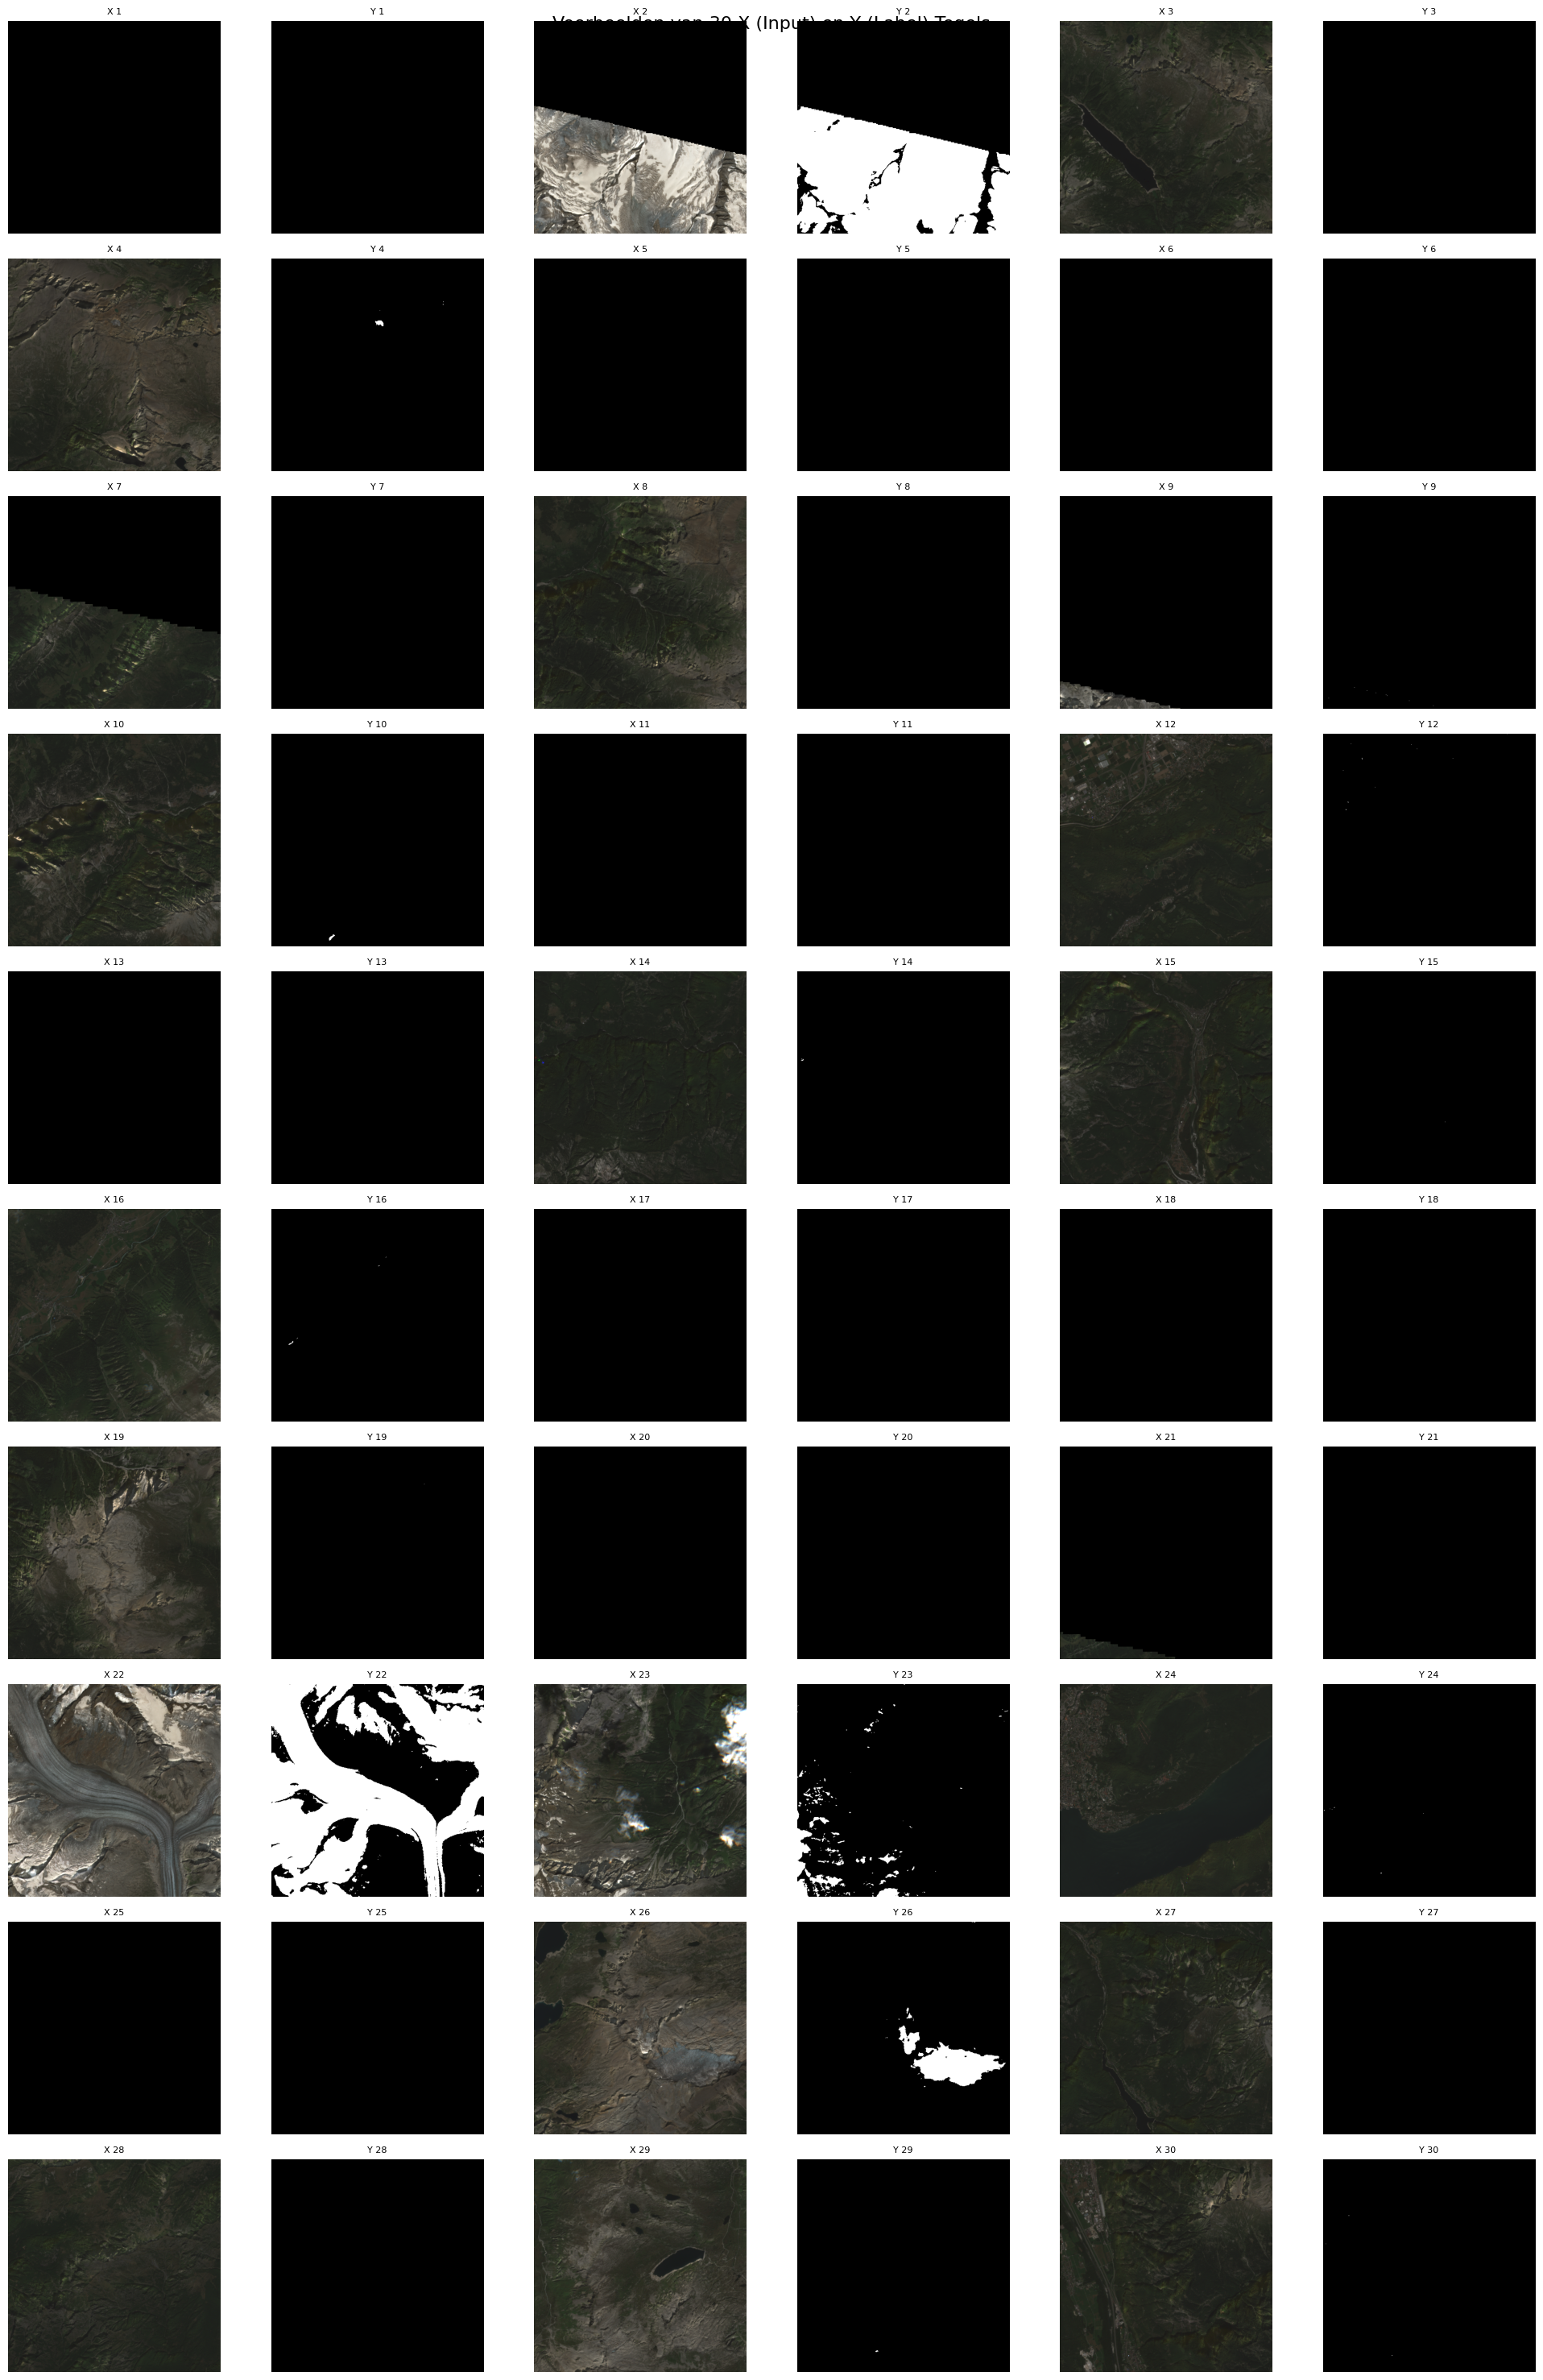

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random

# ⚠️ AANPASSEN: De paden naar jouw opgeslagen tiles
INPUT_DIR_X = 'x/' 
OUTPUT_DIR_Y = 'y/'
VISUALIZATION_COUNT = 30 # Hoeveel paren we willen tonen

# --- Functie om de visualisatie uit te voeren ---

def visualize_tiles(input_dir_x, output_dir_y, count):
    # 1. Zoek alle input bestanden
    all_x_files = glob(os.path.join(input_dir_x, '*_X.npy'))

    if not all_x_files:
        print(f"Fout: Geen .npy bestanden gevonden in {input_dir_x}. Controleer het pad.")
        return

    # Zorg ervoor dat we niet meer vragen dan er bestanden zijn
    if len(all_x_files) < count:
        print(f"Waarschuwing: Er zijn slechts {len(all_x_files)} bestanden gevonden. We tonen ze allemaal.")
        count = len(all_x_files)
    
    # 2. Kies de willekeurige tiles
    selected_x_files = random.sample(all_x_files, count)
    
    # Visualisatie setup: 10 rijen, 3 X-Y paren per rij (6 kolommen totaal)
    N_ROWS = 10
    N_COLS = 6 # (Input X, Label Y) * 3 pairs per row
    
    # Maak een grote figuur
    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(20, 30)) 

    for i in range(count):
        random_x_file = selected_x_files[i]
        
        # KERN OPLOSSING: Haal de bestandsnaam op en bouw het Y-pad opnieuw op
        base_file_name = os.path.basename(random_x_file)
        label_file_name = base_file_name.replace('_X.npy', '_Y.npy') 
        random_y_file = os.path.join(output_dir_y, label_file_name) 

        if not os.path.exists(random_y_file):
            print(f"Fout: Labelbestand {random_y_file} NIET gevonden. Overslaan.")
            continue
        
        try:
            # 3. Laad de data
            tile_X = np.load(random_x_file)
            tile_Y = np.load(random_y_file)
        except Exception as e:
            print(f"Fout bij laden van {random_x_file}: {e}. Overslaan.")
            continue

        # 4. Bereid de Input X voor op weergave (RGB)
        # B04 (index 0), B03 (index 1), B02 (index 2)
        rgb_tile = tile_X[:, :, [0, 1, 2]] 
        
        # Bepaal de positie in het 10x6 grid (i = 0 tot 29)
        row = i // 3 
        col_start = (i % 3) * 2 # 0, 2, 4
        
        # --- Visualisatie Input X (RGB Beeld) ---
        axes[row, col_start].imshow(rgb_tile)
        axes[row, col_start].set_title(f'X {i+1}', fontsize=8)
        axes[row, col_start].axis('off')

        # --- Visualisatie Label Y (Binair Masker) ---
        mask_2d = tile_Y.squeeze() 
        axes[row, col_start + 1].imshow(mask_2d, cmap='gray')
        axes[row, col_start + 1].set_title(f'Y {i+1}', fontsize=8)
        axes[row, col_start + 1].axis('off')

    plt.suptitle(f"Voorbeelden van {count} X (Input) en Y (Label) Tegels", fontsize=16)
    plt.tight_layout()
    
    # Sla de afbeelding op
    output_filename = 'visualisatie_tiles_30.png'
    plt.savefig(output_filename)
    print(f"\n✅ Visualisatie met {count} paren opgeslagen als '{output_filename}'")
    
# Voer de functie uit
visualize_tiles(INPUT_DIR_X, OUTPUT_DIR_Y, VISUALIZATION_COUNT)